In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importnb import imports

Unexpected exception formatting exception. Falling back to standard exception


/Users/kennethwang/Desktop/crop-insurance/notebooks/data_processing.ipynb:1571: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  west_mp.drop(columns=columns_to_drop, inplace=True)
/Users/kennethwang/Desktop/crop-insurance/notebooks/data_processing.ipynb:1572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  east_mp.drop(columns=columns_to_drop, inplace=True)
Traceback (most recent call last):
  File "/Users/kennethwang/opt/miniconda3/envs/crop-insurance/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/hq/62b5kbn9

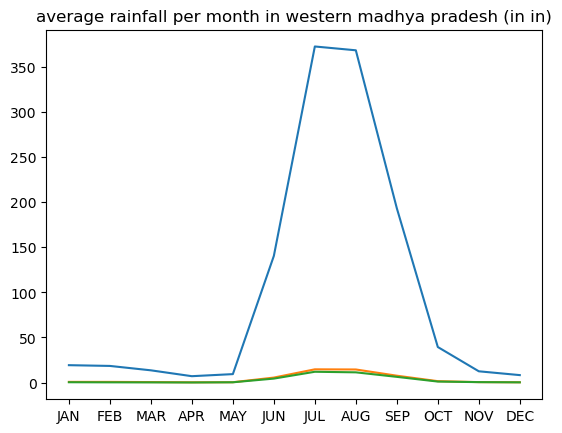

In [12]:
# run the other note book
with imports("ipynb"):
    import data_processing 

# 1. Yield to Cash

In [13]:
# we need to develop the map from yield to cash
#data from marketing study done (2014 Solenkiatal)
# 2,195.00 2,258.00 2,290.00 2,241.00 in rupees per quintal received by the farmer
# but also 69,500.00 in returns, with costs of 32,071.44, so net income around 37,428.56
returns = 66080.00
yields = 20.65 
revenue_per_quintal = returns / yields
fixed_cost = 6251.75
variable_cost = 25711.87 - 901.43 # removed family cost as its not a direct cash cost
total_cost_per_hectare = fixed_cost + variable_cost
total_cost_per_hectare, revenue_per_quintal # 1 quintal = 100 kg of crops
def yield_to_cash_func(predicted_yield, rev_per_q = revenue_per_quintal, total_cost = total_cost_per_hectare): 
    return predicted_yield / 100 * revenue_per_quintal - total_cost

# MAP FROM YIELD TO CASH 

In [14]:
#monte carlo from the distribution of rain years 
#now create simulation by randomly drawing from rainfall distribution, per hectare
def simulate_no_policy(n_trials, n_years, yield_predictor, yield_to_cash = yield_to_cash_func, seed=98765):
    rng = np.random.default_rng(seed)
    rain_trials_years = rng.multivariate_normal(multivar_mean, multivar_cov, size = (n_trials, n_years))
    profit_n_trials = []
    cash_each_year = []
    yield_n_trials = []
    for i in range(n_trials):
        trial_i = rain_trials_years[i]
        yield_i = yield_predictor.predict(trial_i)
        yield_n_trials.append(yield_i)
        cash_change = yield_to_cash(yield_i)
        cash_each_year.append(cash_change)
        profit_n_trials.append(np.sum(cash_change))
        if np.sum(cash_change) > 5000:
            print(i)
    return profit_n_trials, yield_n_trials, rain_trials_years, cash_each_year
#calculate cumulative cash
def cash_accumulation(cash_each_year):
    return_list = []
    for i in range(len(cash_each_year)):
        if i == 0: 
            return_list.append(cash_each_year[i])
        else: 
            return_list.append(cash_each_year[i] + return_list[i-1])
    return return_list

no_policy_output = simulate_no_policy(100, 10, lin_reg_india)

 # single hectare
# under these assumptions, insurance less always results in a loss in the long run 
no_policy_profit, no_policy_yield, no_policy_rain, no_policy_cash = no_policy_output[0], no_policy_output[1], no_policy_output[2], no_policy_output[3]
print(np.mean(no_policy_profit))
plt.plot(no_policy_profit)
    

NameError: name 'lin_reg_india' is not defined

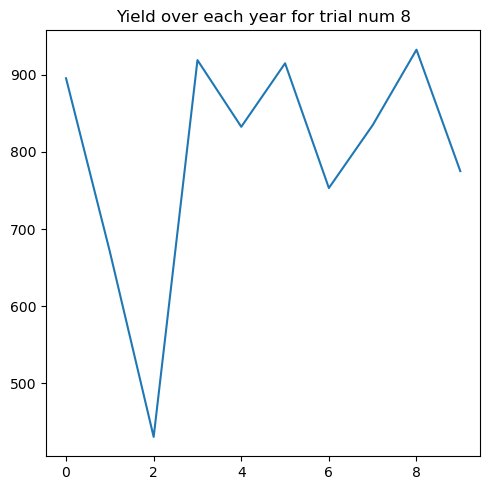

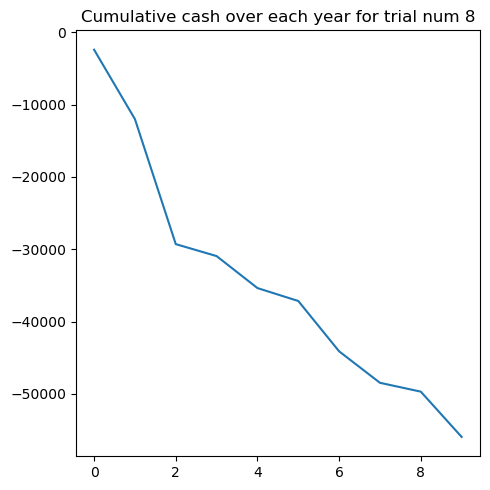

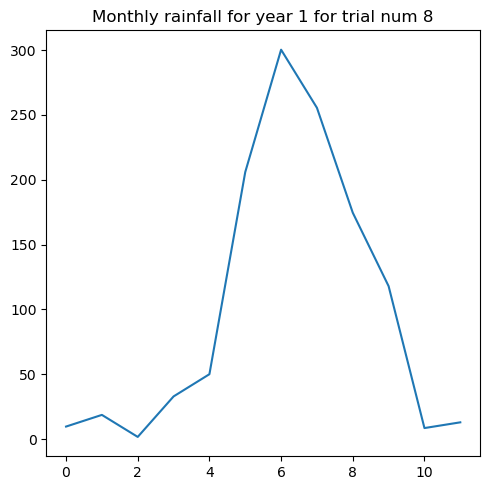

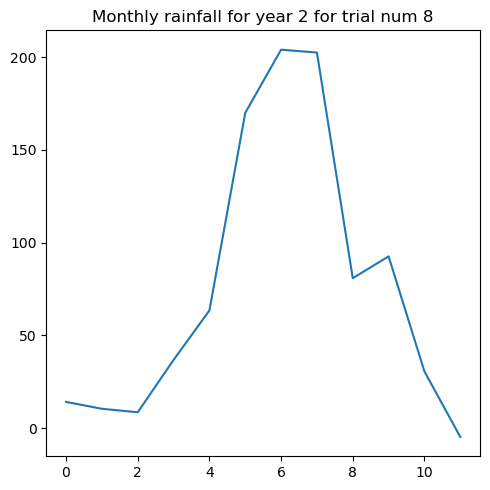

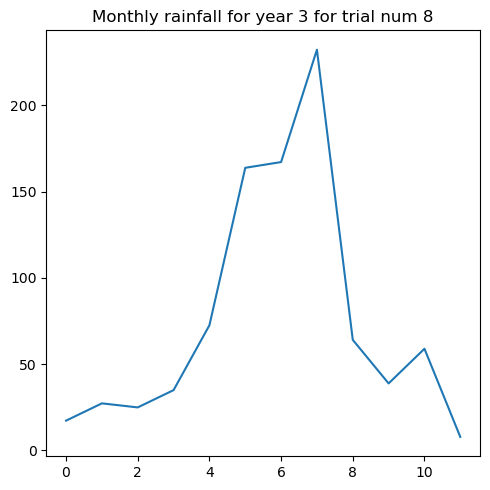

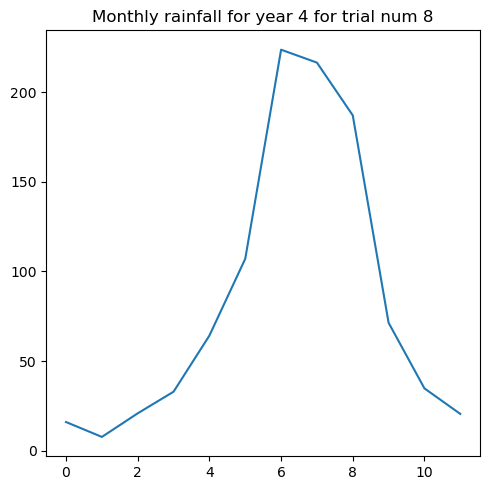

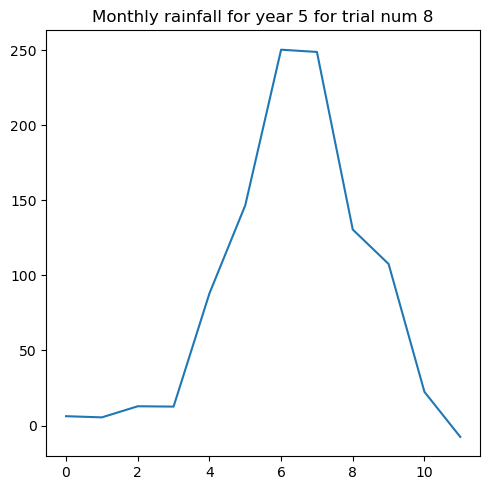

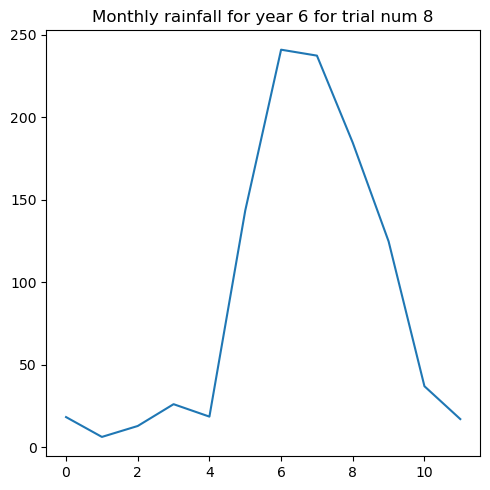

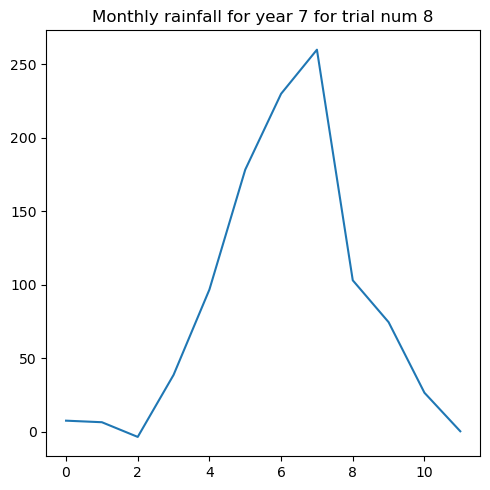

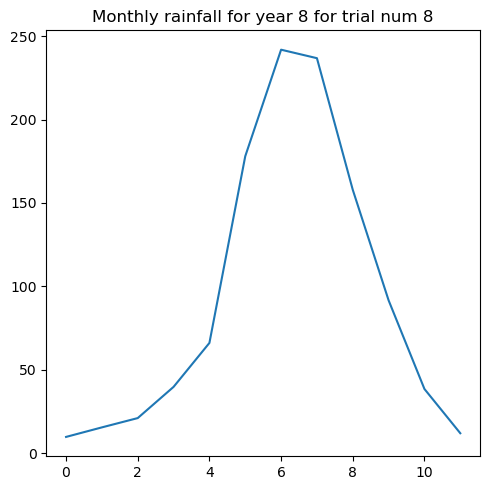

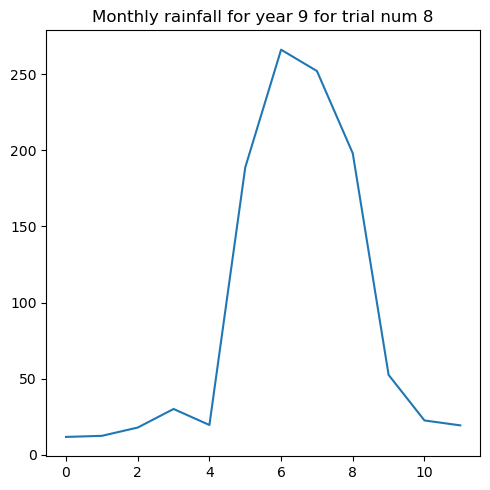

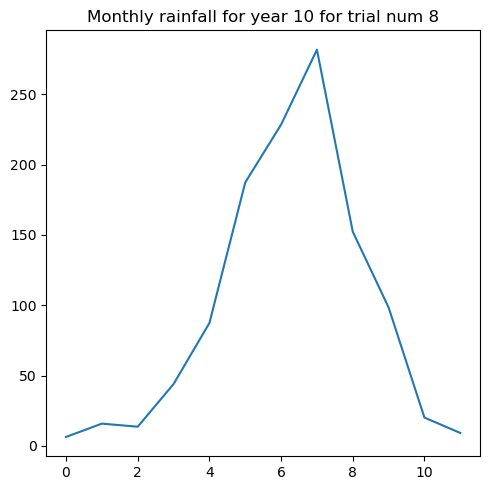

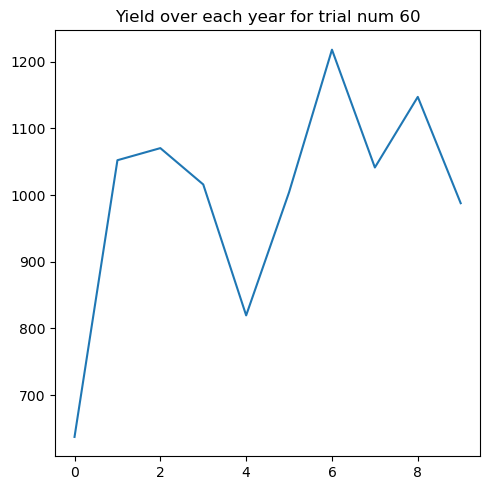

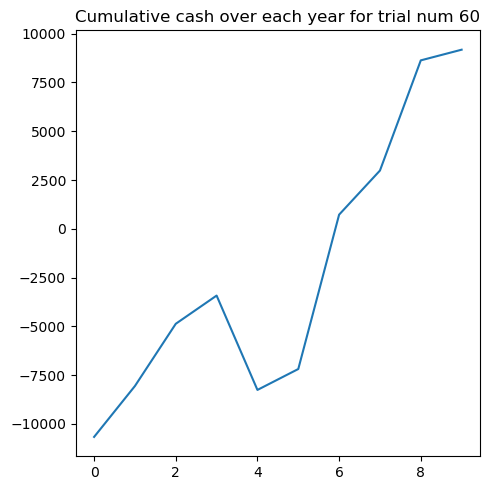

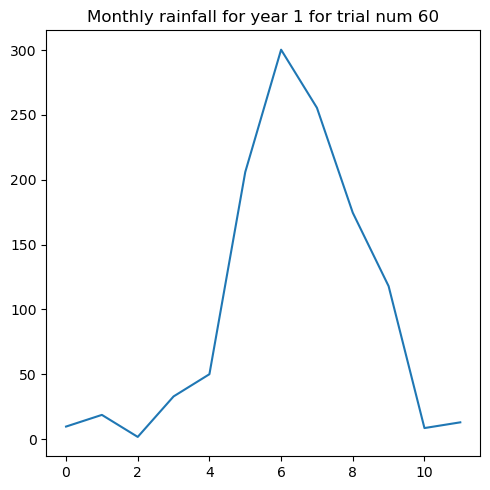

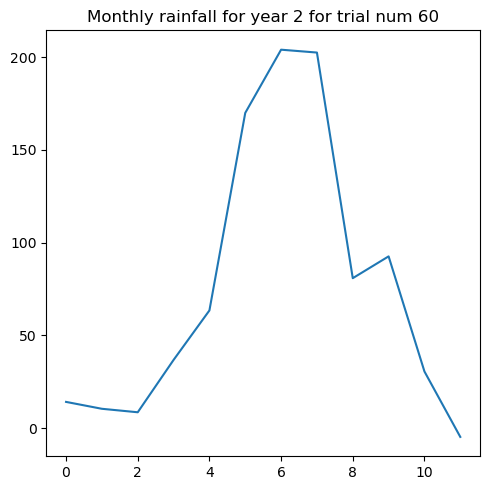

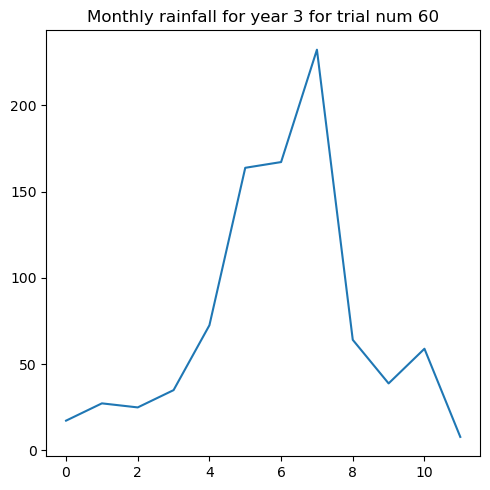

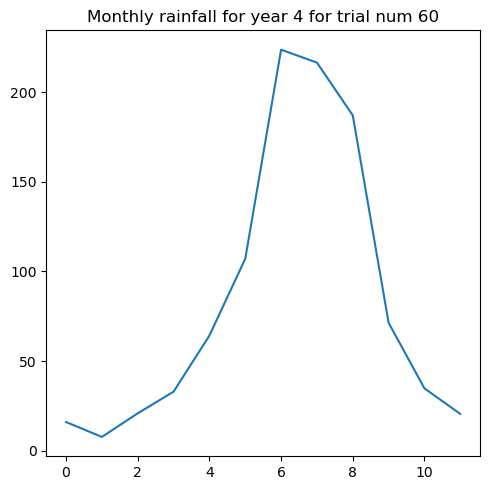

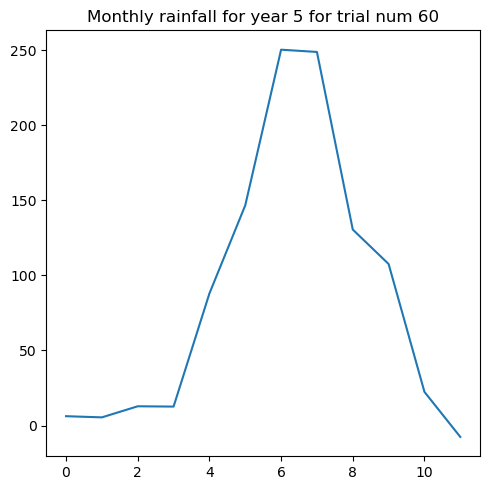

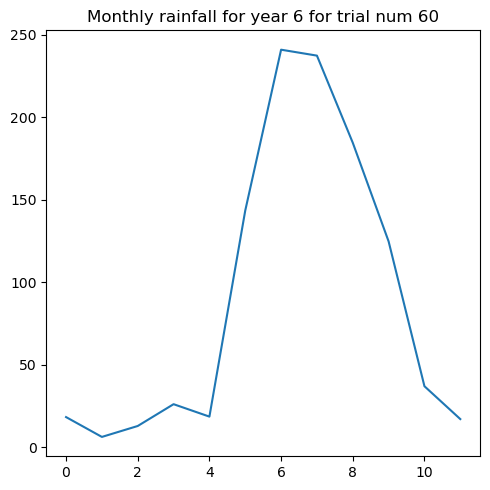

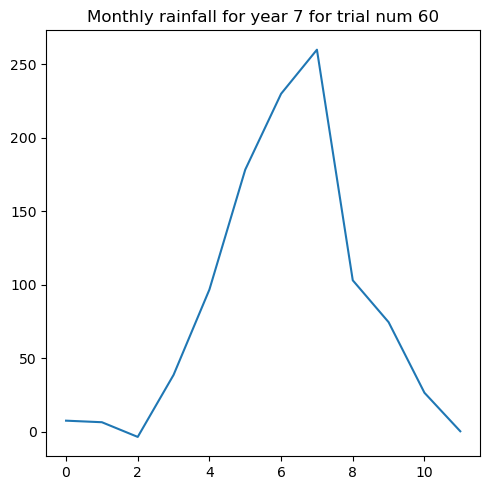

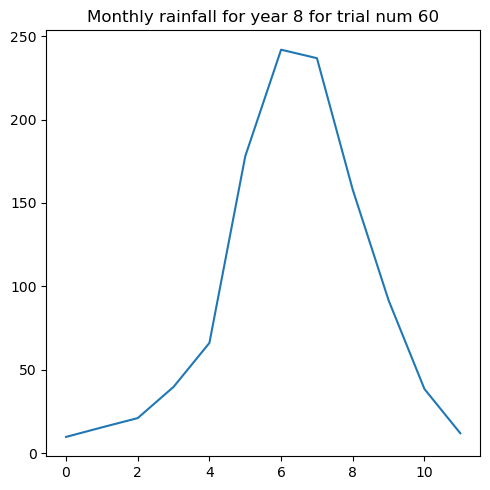

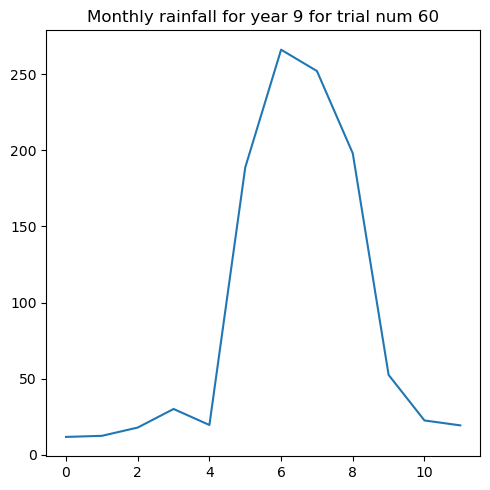

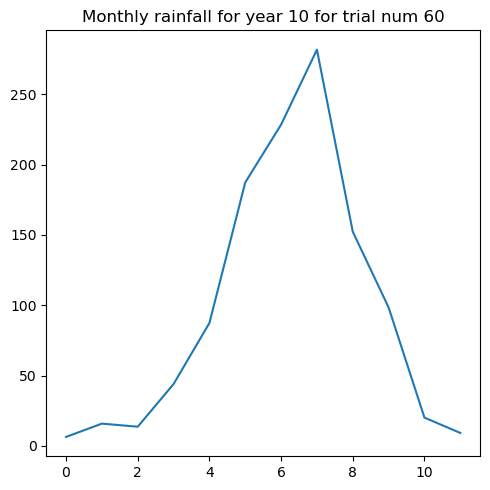

(None, None)

In [10]:

def plot_summary_trial(sim_out, trial_num = 0): 
    profit, yields, rain, cash = sim_out[0], sim_out[1], sim_out[2], sim_out[3]
    #plot yields
    plt.figure()
    plt.title("Yield over each year for trial num " + str(trial_num))
    plt.plot(yields[trial_num])
    #plot cash
    plt.figure()
    plt.title("Cumulative cash over each year for trial num " + str(trial_num))
    plt.plot(cash_accumulation(cash[trial_num]))
    #plot monthly rainfall per year
    for _ in range(len(no_policy_rain[8])):
        plt.figure(str(_))
        plt.title("Monthly rainfall for year " + str(_ + 1) + " for trial num " + str(trial_num))
        plt.plot(no_policy_rain[8][_])
    plt.show()
plot_summary_trial(no_policy_output, 8), plot_summary_trial(no_policy_output, 60)



In [9]:

#now try naive single payout, single lower threshold insurance policy simulation
def simulate_naive_simple(n_trials, n_years, lower_threshold, payout, seed=98765):
    rng = np.random.default_rng(seed)
    random_years = rng.normal(east_monsoon_mean, east_monsoon_std, size = (n_trials,n_years))
    profit_n_trials = []
    for _ in range(n_trials):
        rainfall_i = random_years[_]
        insurance_payouts_i = [payout if x < lower_threshold else 0 for x in rainfall_i]
        quad_i = quadratic.fit_transform(random_years[_].reshape(-1,1))
        yield_i = quadratic_model.predict(quad_i)
        profit_i = revenue_per_quintal * ( yield_i / 100 ) - total_cost_per_hectare + insurance_payouts_i
        profit_n_trials.append(np.sum(profit_i))
    return profit_n_trials
naive_simple_profits = simulate_naive_simple(100, 1, low_thresh, 400)
plt.plot(naive_simple_profits)
#now try naive single payout, double threshold insurance policy simulation
def simulate_double_threshold(n_trials, n_years, lower_threshold, upper_threshold, lower_payout, upper_payout, seed=98765):
    rng = np.random.default_rng(seed)
    random_years = rng.normal(east_monsoon_mean, east_monsoon_std, size = (n_trials,n_years))
    profit_n_trials = []
    rainfall_n_trials = []
    for _ in range(n_trials):
        rainfall_i = random_years[_]
        insurance_payouts_i = []
        for x in rainfall_i:
            if x < lower_threshold:
                insurance_payouts_i.append(lower_payout)
            elif x > upper_threshold:
                insurance_payouts_i.append(upper_payout)
            else:
                insurance_payouts_i.append(0)
        quad_i = quadratic.fit_transform(random_years[_].reshape(-1,1))
        yield_i = quadratic_model.predict(quad_i)
        rainfall_n_trials.append(yield_i)
        profit_i = revenue_per_quintal * ( yield_i / 100 ) - total_cost_per_hectare + insurance_payouts_i
        profit_n_trials.append(np.sum(profit_i))
    plt.plot(profit_n_trials)
    return profit_n_trials
double_threshold_profits = simulate_double_threshold(100, 1, low_thresh, up_thresh, 200, 200)
#insurance policy parameters, in expectation 
plt.plot(double_threshold_profits)
#now try naive linear payout, single lower threshold insurance policy simulation
def simulate_linear_payout(n_trials, n_years, lower_threshold, lower_payout, seed=98765):
    rng = np.random.default_rng(seed)
    random_years = rng.normal(east_monsoon_mean, east_monsoon_std, size = (n_trials,n_years))
    profit_n_trials = []
    for _ in range(n_trials):
        rainfall_i = random_years[_]
        insurance_payouts_i = []
        for x in rainfall_i:
            if x < lower_threshold:
                insurance_payouts_i.append(lower_payout * (lower_threshold - x))
            else:
                insurance_payouts_i.append(0)
        quad_i = quadratic.fit_transform(random_years[_].reshape(-1,1))
        yield_i = quadratic_model.predict(quad_i)
        profit_i = revenue_per_quintal * ( yield_i / 100 ) - total_cost_per_hectare + insurance_payouts_i
        profit_n_trials.append(np.sum(profit_i))
    plt.plot(profit_n_trials)
    return profit_n_trials
linear_profits = simulate_linear_payout(100, 1, low_thresh, 10)

NameError: name 'low_thresh' is not defined